# 数据预处理

In [1]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization,concatenate, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt

with h5py.File('./DB3/DB3_S1_image.h5', 'r') as f:
    imageData = f['imageData'][:]
    imageData = imageData * 2000
    imageLabel = f['imageLabel'][:]

# 随机打乱数据和标签
N = imageData.shape[0]
index = np.random.permutation(N)
data  = imageData[index, :, :]
label = imageLabel[index]

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# 对数据升维 标签one-hot
data = np.expand_dims(data, axis=3)
label = convert_to_one_hot(label, 16).T

# 划分数据集
N = data.shape[0]
num_train = round(N * 0.8)
X_train = data[0:num_train, :, :]
Y_train = label[0:num_train, :]
X_test  = data[num_train:N, :, :]
Y_test  = label[num_train:N, :]

print('X_train shape:', str(X_train.shape))
print('Y_train shape:', str(Y_train.shape))
print('X_test shape:', str(X_test.shape))
print('Y_test shape:', str(Y_test.shape))

X_train shape: (3827, 200, 6, 1)
Y_train shape: (3827, 16)
X_test shape: (957, 200, 6, 1)
Y_test shape: (957, 16)


In [2]:
# 写一个LossHistory类 保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc='upper right')
        plt.show()

# 建立模型

In [3]:
def CNN(input_shape=(200, 6, 1), classes=16): 
    X_input = Input(input_shape)
    f1 = [20, 16, 12, 8]
    f2 = [3, 4, 5, 6]
    convs = []
    for i in range(4):
        x = Conv2D(filters=32, kernel_size=(f1[i], 3), strides=(1, 1), activation='relu',padding='valid')(X_input)
        x = MaxPooling2D((20, 1))(x)
        x = Conv2D(filters=64, kernel_size=(f2[i], 1), strides=(1, 1), activation='relu', padding='valid')(x)
        x = MaxPooling2D((9 - 2 - i, 1))(x)
        x = Flatten()(x)
        convs.append(x)
    merge = concatenate(convs, axis=1)
    X = merge
    X = Dropout(0.5)(X)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax')(X)
    model = Model(inputs=X_input, outputs=X)
    return model

model = CNN()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 6, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 181, 4, 32)   1952        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 185, 4, 32)   1568        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 189, 4, 32)   1184        input_1[0][0]                    
______________________________________________________________________________________________

# 训练原始数据

In [4]:
import time

start = time.time()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = LossHistory() # 创建一个history实例
model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=64, callbacks=[history])

preds_train = model.evaluate(X_train, Y_train)
print('Train Loss =', str(preds_train[0]))
print('Train Accuracy =', str(preds_train[1]))

preds_test = model.evaluate(X_test, Y_test)
print('Test Loss =', str(preds_test[0]))
print('Test Accuracy =', str(preds_test[1]))

end = time.time()
print('time:', end - start)

Epoch 1/100
60/60 [==============================] - 6s 107ms/step - loss: 2.4504 - acc: 0.1832 - val_loss: 1.7502 - val_acc: 0.4828
Epoch 2/100
60/60 [==============================] - 6s 96ms/step - loss: 1.6863 - acc: 0.4147 - val_loss: 1.1187 - val_acc: 0.6322
Epoch 3/100
60/60 [==============================] - 6s 102ms/step - loss: 1.2615 - acc: 0.5623 - val_loss: 0.8474 - val_acc: 0.7513
Epoch 4/100
60/60 [==============================] - 6s 106ms/step - loss: 1.0199 - acc: 0.6384 - val_loss: 0.6500 - val_acc: 0.8234
Epoch 5/100
60/60 [==============================] - 7s 111ms/step - loss: 0.8662 - acc: 0.6870 - val_loss: 0.5696 - val_acc: 0.8443
Epoch 6/100
60/60 [==============================] - 7s 116ms/step - loss: 0.7688 - acc: 0.7293 - val_loss: 0.5173 - val_acc: 0.8171
Epoch 7/100
60/60 [==============================] - 7s 118ms/step - loss: 0.6665 - acc: 0.7648 - val_loss: 0.4355 - val_acc: 0.8694
Epoch 8/100
60/60 [==============================] - 7s 122ms/step - l

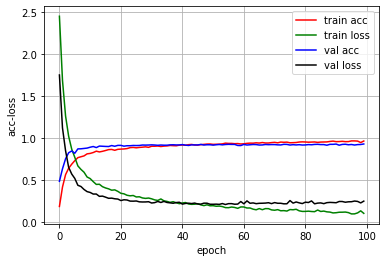

In [5]:
history.loss_plot('epoch')